In [18]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

from resnet_features import resnet18_features, resnet34_features, resnet50_features, resnet101_features, resnet152_features
from densenet_features import densenet121_features, densenet161_features, densenet169_features, densenet201_features
from vgg_features import vgg11_features, vgg11_bn_features, vgg13_features, vgg13_bn_features, vgg16_features, vgg16_bn_features,\
                         vgg19_features, vgg19_bn_features

from receptive_field import compute_proto_layer_rf_info_v2

from settings import img_size

from PIL import Image
import numpy as np
import numpy.random as npr
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch.utils.data
# import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim

import pickle as pkl
import skimage as sk
import skimage.io as skio
from preference_model import construct_PrefNet, paired_cross_entropy_loss, PrefNet

# book keeping namings and code
from settings import base_architecture, img_size, prototype_shape, num_classes, \
                     prototype_activation_function, add_on_layers_type, experiment_run

from preprocess import mean, std, preprocess_input_function
from tqdm import tqdm

In [19]:
base_architecture_to_features = {'resnet18': resnet18_features,
                                 'resnet34': resnet34_features,
                                 'resnet50': resnet50_features,
                                 'resnet101': resnet101_features,
                                 'resnet152': resnet152_features,
                                 'densenet121': densenet121_features,
                                 'densenet161': densenet161_features,
                                 'densenet169': densenet169_features,
                                 'densenet201': densenet201_features,
                                 'vgg11': vgg11_features,
                                 'vgg11_bn': vgg11_bn_features,
                                 'vgg13': vgg13_features,
                                 'vgg13_bn': vgg13_bn_features,
                                 'vgg16': vgg16_features,
                                 'vgg16_bn': vgg16_bn_features,
                                 'vgg19': vgg19_features,
                                 'vgg19_bn': vgg19_bn_features}


class PrefNet(nn.Module):

    def __init__(self, img_features, pattern_features, img_size, prototype_shape,
                 proto_layer_rf_info, num_classes, init_weights=True,
                 prototype_activation_function='log',
                 add_on_layers_type='bottleneck', 
                k = 3):

        super(PrefNet, self).__init__()
        self.img_size = img_size
        self.prototype_shape = prototype_shape
        self.num_prototypes = prototype_shape[0]
        self.num_classes = num_classes
        self.epsilon = 1e-4
        self.k = k
        
        # this has to be named features to allow the precise loading
        self.img_features = img_features
        self.pattern_features = pattern_features
        
        
        
        features_name = str(self.img_features).upper()
        if features_name.startswith('VGG') or features_name.startswith('RES'):
            first_add_on_layer_in_channels = \
                [i for i in img_features.modules() if isinstance(i, nn.Conv2d)][-1].out_channels
        elif features_name.startswith('DENSE'):
            first_add_on_layer_in_channels = \
                [i for i in img_features.modules() if isinstance(i, nn.BatchNorm2d)][-1].num_features
        else:
            raise Exception('other base base_architecture NOT implemented')

        if add_on_layers_type == 'bottleneck':
            add_on_layers = []
            current_in_channels = first_add_on_layer_in_channels
            while (current_in_channels > self.prototype_shape[1]) or (len(add_on_layers) == 0):
                current_out_channels = max(self.prototype_shape[1], (current_in_channels // 2))
                add_on_layers.append(nn.Conv2d(in_channels=current_in_channels,
                                               out_channels=current_out_channels,
                                               kernel_size=1))
                add_on_layers.append(nn.ReLU())
                add_on_layers.append(nn.Conv2d(in_channels=current_out_channels,
                                               out_channels=current_out_channels,
                                               kernel_size=1))
                if current_out_channels > self.prototype_shape[1]:
                    add_on_layers.append(nn.ReLU())
                else:
                    assert(current_out_channels == self.prototype_shape[1])
                    add_on_layers.append(nn.Sigmoid())
                current_in_channels = current_in_channels // 2
            self.img_add_on_layers = nn.Sequential(*add_on_layers)
        else:
            self.img_add_on_layers = nn.Sequential(
                nn.Conv2d(in_channels=first_add_on_layer_in_channels, out_channels=self.prototype_shape[1], kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=self.prototype_shape[1], out_channels=self.prototype_shape[1], kernel_size=1),
                nn.Sigmoid()
                )
        
        
        
        
        features_name = str(self.pattern_features).upper()
        if features_name.startswith('VGG') or features_name.startswith('RES'):
            first_add_on_layer_in_channels = \
                [i for i in pattern_features.modules() if isinstance(i, nn.Conv2d)][-1].out_channels
        elif features_name.startswith('DENSE'):
            first_add_on_layer_in_channels = \
                [i for i in pattern_features.modules() if isinstance(i, nn.BatchNorm2d)][-1].num_features
        else:
            raise Exception('other base base_architecture NOT implemented')

        if add_on_layers_type == 'bottleneck':
            add_on_layers = []
            current_in_channels = first_add_on_layer_in_channels
            while (current_in_channels > self.prototype_shape[1]) or (len(add_on_layers) == 0):
                current_out_channels = max(self.prototype_shape[1], (current_in_channels // 2))
                add_on_layers.append(nn.Conv2d(in_channels=current_in_channels,
                                               out_channels=current_out_channels,
                                               kernel_size=1))
                add_on_layers.append(nn.ReLU())
                add_on_layers.append(nn.Conv2d(in_channels=current_out_channels,
                                               out_channels=current_out_channels,
                                               kernel_size=1))
                if current_out_channels > self.prototype_shape[1]:
                    add_on_layers.append(nn.ReLU())
                else:
                    assert(current_out_channels == self.prototype_shape[1])
                    add_on_layers.append(nn.Sigmoid())
                current_in_channels = current_in_channels // 2
            self.pattern_add_on_layers = nn.Sequential(*add_on_layers)
        else:
            self.pattern_add_on_layers = nn.Sequential(
                nn.Conv2d(in_channels=first_add_on_layer_in_channels, out_channels=self.prototype_shape[1], kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=self.prototype_shape[1], out_channels=self.prototype_shape[1], kernel_size=1),
                nn.Sigmoid()
                )
            
            
            
#         self.prototype_vectors = nn.Parameter(torch.rand(self.prototype_shape),
#                                               requires_grad=True)

#         # do not make this just a tensor,
#         # since it will not be moved automatically to gpu
#         self.ones = nn.Parameter(torch.ones(self.prototype_shape),
#                                  requires_grad=False)

#         self.last_layer = nn.Linear(self.num_prototypes, self.num_classes,
#                                     bias=False) # do not use bias


        self.img_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.pattern_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        
        self.img_fc = nn.Linear(512 * 7 * 7, 3200)
        self.pattern_fc = nn.Linear(512 * 7 * 7, 3200)
        self.fc1 = nn.Linear(6400, 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 1)

        if init_weights:
            self._initialize_weights()
            
            
    def conv_features(self, x):
        '''
        the feature input to prototype layer
        '''
        # Insert k and then img size
        x = self.features(x)
        x = self.add_on_layers(x)
        return x
    
    def forward(self, x, p):
        # (N, 512, 7, 7)
        #x = self.conv_features(x)
        x = self.img_features(x)
        x = self.img_add_on_layers(x)
        #x = self.img_conv(x)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.img_fc(x)
        #print("img_conv out shape: ", x.shape)
        
        #p = self.conv_features(p)
        p = self.pattern_features(p)
        p = self.pattern_add_on_layers(p)
        p = torch.flatten(p, 1)
        #p = self.pattern_conv(p)
        p = self.pattern_fc(p)
        #print("pattern_conv out shape: ", p.shape)
        
        out = torch.cat((x, p), dim=1)
        #print("cat out shape: ", out.shape)
        out = torch.flatten(out, 1) # flatten all dimensions except batch
        #print("flatten out shape: ", out.shape)
        
       
        out = torch.sigmoid(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        out = self.fc3(out)
        return out

    
    def _initialize_weights(self):
        for m in self.img_add_on_layers.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        for m in self.pattern_add_on_layers.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)




            
def construct_PrefNet(base_architecture, pretrained=True, img_size=224,
                    prototype_shape=(2000, 512, 1, 1), num_classes=200,
                    prototype_activation_function='log',
                    add_on_layers_type='bottleneck',
                    k = 3):
    img_features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    pattern_features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    layer_filter_sizes, layer_strides, layer_paddings = img_features.conv_info()
    proto_layer_rf_info = compute_proto_layer_rf_info_v2(img_size=img_size,
                                                         layer_filter_sizes=layer_filter_sizes,
                                                         layer_strides=layer_strides,
                                                         layer_paddings=layer_paddings,
                                                         prototype_kernel_size=prototype_shape[2])
    return PrefNet(img_features=img_features,
                 pattern_features=pattern_features,
                 img_size=img_size,
                 prototype_shape=prototype_shape,
                 proto_layer_rf_info=proto_layer_rf_info,
                 num_classes=num_classes,
                 init_weights=True,
                 prototype_activation_function=prototype_activation_function,
                 add_on_layers_type=add_on_layers_type,
                 k = k)


def paired_cross_entropy_loss(out1, out2, targets):
    
    total_loss = 0
    for i in range(len(targets)):
        
        if targets[i] == -1:
            p1 = torch.exp(out1[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - torch.log(p1)
        elif targets[i] == 1:
            p2 = torch.exp(out2[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - torch.log(p2)

        else:
            p1 = torch.exp(out1[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            p2 = torch.exp(out2[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - (0.5*torch.log(p1) + 0.5*torch.log(p2))
            
        total_loss += loss
    return total_loss


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [21]:
normalize = transforms.Normalize(mean=mean,
                                 std=std)

trans = transforms.Compose([
    transforms.Resize(size=(img_size, img_size)),
    transforms.ToTensor(),
    normalize
])

In [22]:
k = 1
csv_name = "./human_comparisons/rating_s=5_k=1_700_random_1.csv"
if os.path.exists(csv_name):
    comp_df = pd.read_csv(csv_name)

(array([ 76.,   0.,  51.,   0.,   0.,  44.,   0., 120.,   0., 409.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

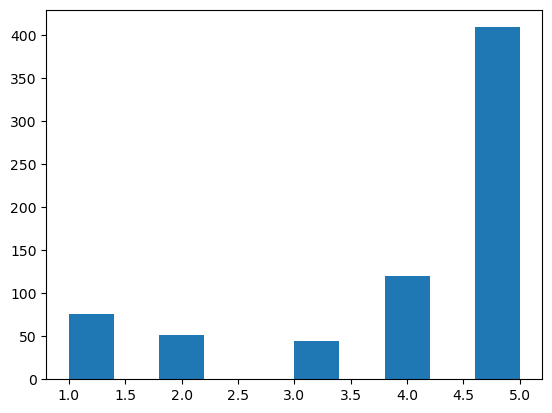

In [23]:
plt.hist(comp_df['rating'])
        

In [24]:
csv_name = "./human_comparisons/rating_s=5_k=1_500.csv"
if os.path.exists(csv_name):
    comp_df = pd.read_csv(csv_name)

(array([ 25.,   0.,  26.,   0.,   0.,  62.,   0., 100.,   0., 287.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

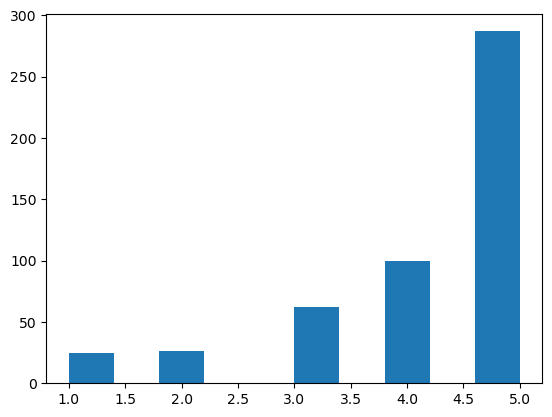

In [25]:
plt.hist(comp_df['rating'])

In [6]:
split = 0.8
df_len = len(comp_df)
train_set = []
test_set = []
split_idx = int(df_len*split)
for i in range(split_idx):
    for j in range(i+1, split_idx):
        if comp_df.iloc[i]['rating'] > comp_df.iloc[j]['rating']:
            train_set.append([i, j, -1])
        elif comp_df.iloc[i]['rating'] < comp_df.iloc[j]['rating']:
            train_set.append([i, j, 1])
            
for i in range(split_idx, df_len):
    for j in range(i+1, df_len):
        if comp_df.iloc[i]['rating'] > comp_df.iloc[j]['rating']:
            test_set.append([i, j, -1])
        elif comp_df.iloc[i]['rating'] < comp_df.iloc[j]['rating']:
            test_set.append([i, j, 1])
print(len(train_set))
print(len(test_set))

96462
5668


In [7]:
'''
another way of splitting data
'''
#split = 0.7
#train_set = training_set[:int(len(training_set) * split)]
#test_set = training_set[int(len(training_set) * split):]
#print(len(train_set))
#print(len(test_set))

'\nanother way of splitting data\n'

In [8]:
images = []
patterns = []
for i in range(df_len):
    img = './human_comparisons/feedback_images/k=1_random/original_imgs/' + comp_df.iloc[i]['imgid'] + '.png'
    img = plt.imread(img)[:, :, :3]
    img = np.transpose(img, (2, 0, 1))
    images.append(torch.from_numpy(np.array([img])))
    pattern = './human_comparisons/feedback_images/k=1_random/patterns/' + comp_df.iloc[i]['imgid'] + '.npy'
    pattern = np.load(pattern)
    pattern = np.array([pattern, pattern, pattern])
    patterns.append(torch.from_numpy(np.array([pattern])))
print(len(images))
print(images[100].shape)
print(patterns[100].shape)

700
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [13]:
prefnet = construct_PrefNet("resnet50")
prefnet.to(device)
prefnet.train()
pref_optimizer = optim.Adam([{'params': prefnet.img_features.parameters(), 'lr': 1e-4}, {'params': prefnet.pattern_features.parameters(), 'lr': 1e-4}, 
                             {'params': prefnet.img_fc.parameters(), 'lr': 1e-4}, {'params': prefnet.pattern_fc.parameters(), 'lr': 1e-4},
                             {'params': prefnet.img_add_on_layers.parameters(), 'lr': 1e-4}, {'params': prefnet.pattern_add_on_layers.parameters(), 'lr': 1e-4},
                             {'params': prefnet.img_conv.parameters(), 'lr': 1e-4}, {'params': prefnet.pattern_conv.parameters(), 'lr': 1e-4}, 
                             {'params': prefnet.fc1.parameters(), 'lr': 1e-4}, {'params': prefnet.fc2.parameters(), 'lr': 1e-4}, {'params': prefnet.fc3.parameters(), 'lr': 1e-4}])

In [14]:
prefnet(images[10].cuda(), patterns[10].cuda())

tensor([[-0.0322]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [15]:
epochs = 5
batch_size = 32

In [12]:
pref_optimizer = optim.Adam([{'params': prefnet.img_conv.parameters(), 'lr': 1e-5}, {'params': prefnet.pattern_conv.parameters(), 'lr': 1e-5}, {'params': prefnet.fc1.parameters(), 'lr': 1e-5},
                            {'params': prefnet.fc2.parameters(), 'lr': 1e-5}, {'params': prefnet.fc3.parameters(), 'lr': 1e-5}])

In [16]:
def test_reward_model(prefnet, test_set, images, patterns):
    acc = []
    #error_images = []
    error_count = 0
    for i in tqdm(range(len(test_set))):
        left_idx, right_idx, target = test_set[i]
        left_img, right_img = images[left_idx], images[right_idx]
        left_pattern, right_pattern = patterns[left_idx], patterns[right_idx]
        target = torch.tensor(target).cuda().float()

        out1 = prefnet(left_img.cuda().float(), left_pattern.cuda().float())
        out2 = prefnet(right_img.cuda().float(), right_pattern.cuda().float())
        #print(out1)
        #print(out2)


        if out1 > out2:
            y_pred = -1

        else:
            y_pred = 1

        #print(y_pred)
        #print("")
        if y_pred == target:
            acc.append(1)
        else:
            #error_images.append((i, y_pred, target))
            error_count += 1
            acc.append(0)
            
    return np.mean(acc), error_count

In [17]:
for epoch in range(epochs):
    shuffled_idx = np.random.permutation(len(train_set))
    for batch_i in range(len(train_set)//batch_size + 1):
        if batch_i % 100 == 0:
            last_100_losses = []
            last_100_error_count = 0
        idx = shuffled_idx[batch_i*batch_size:(batch_i+1)*batch_size]
        
        left_imgs = torch.zeros((batch_size, 3, 224, 224))
        right_imgs = torch.zeros((batch_size, 3, 224, 224))
        left_patterns = torch.zeros((batch_size, 3, 224, 224))
        right_patterns = torch.zeros((batch_size, 3, 224, 224))
        targets = []
        for i in range(len(idx)):
            index = idx[i]
            left_imgs[i] = images[train_set[index][0]][0]
            right_imgs[i] = images[train_set[index][1]][0]
            targets.append(train_set[index][2])
            left_patterns[i] = patterns[train_set[index][0]][0]
            right_patterns[i] = patterns[train_set[index][1]][0]
        
        targets = torch.tensor(targets).cuda().float()
        
        out1 = prefnet(left_imgs.cuda().float(), left_patterns.cuda().float())
        out2 = prefnet(right_imgs.cuda().float(), right_patterns.cuda().float())

        
        pref_optimizer.zero_grad()   
        
        for i in range(len(targets)):
            if out1[i] > out2[i] and targets[i] == 1:
                last_100_error_count += 1

            elif out1[i] < out2[i] and targets[i] == -1:
                last_100_error_count += 1
                
        loss = paired_cross_entropy_loss(out1, out2, targets)
        
        loss.backward()
        pref_optimizer.step()   
        
        last_100_losses.append(loss.data.cpu().numpy()[0])
        
        if batch_i % 100 == 0:
            print(epoch, batch_i, np.sum(last_100_losses))
        if batch_i % 100 == 99:
            print(epoch, batch_i, last_100_error_count)
        if batch_i % 1000 == 999:
            test_acc, test_error_count = test_reward_model(prefnet, test_set, images, patterns)
            print(epoch, batch_i, test_acc, test_error_count)

0 0 22.184793
0 99 450
0 100 14.297962
0 199 252
0 200 5.1353197
0 299 209
0 300 5.857233
0 399 175
0 400 5.807886
0 499 163
0 500 3.5191991
0 599 170
0 600 2.889525
0 699 165
0 700 2.675007
0 799 110
0 800 3.3982656
0 899 80
0 900 5.0861344
0 999 79


100%|██████████| 5668/5668 [02:45<00:00, 34.30it/s]


0 999 0.6367325335215244 2059
0 1000 0.9982669
0 1099 83
0 1100 2.6490378
0 1199 82
0 1200 2.9638603
0 1299 67
0 1300 0.57401335
0 1399 67
0 1400 1.6640669
0 1499 97
0 1500 5.312115
0 1599 118
0 1600 1.9212143
0 1699 133
0 1700 10.714208
0 1799 91
0 1800 2.4598808
0 1899 40
0 1900 1.9612269
0 1999 34


100%|██████████| 5668/5668 [02:45<00:00, 34.29it/s]


0 1999 0.6337332392378264 2076
0 2000 1.4717791
0 2099 20
0 2100 1.1694398
0 2199 14
0 2200 3.4615276
0 2299 25
0 2300 1.9244483
0 2399 20
0 2400 0.9921782
0 2499 20
0 2500 0.6528253
0 2599 12
0 2600 1.633644
0 2699 23
0 2700 0.70512575
0 2799 19
0 2800 0.33356002
0 2899 21
0 2900 1.114428
0 2999 22


100%|██████████| 5668/5668 [02:43<00:00, 34.59it/s]


0 2999 0.6886026817219478 1765
0 3000 0.48828435
1 0 0.59915525
1 99 19
1 100 1.1854101
1 199 125
1 200 3.2929416
1 299 72
1 300 0.87660706
1 399 54
1 400 1.8347942
1 499 23
1 500 1.6536994
1 599 22
1 600 1.3824136
1 699 12
1 700 0.37911347
1 799 19
1 800 0.59483147
1 899 18
1 900 1.0613755
1 999 11


100%|██████████| 5668/5668 [02:43<00:00, 34.64it/s]


1 999 0.6441425546930134 2017
1 1000 0.9689445
1 1099 13
1 1100 1.9752756
1 1199 53
1 1200 2.3789754
1 1299 30
1 1300 0.39389306
1 1399 22
1 1400 0.70361847
1 1499 16
1 1500 1.8075132
1 1599 11
1 1600 0.32634842
1 1699 5
1 1700 0.3237077
1 1799 8
1 1800 0.33987722
1 1899 12
1 1900 0.34683233
1 1999 11


100%|██████████| 5668/5668 [02:43<00:00, 34.68it/s]


1 1999 0.6137967537050106 2189
1 2000 0.20938529
1 2099 7
1 2100 0.18075247
1 2199 7
1 2200 1.100905
1 2299 18
1 2300 0.45912367
1 2399 10
1 2400 0.22526167
1 2499 14
1 2500 0.7180519
1 2599 5
1 2600 0.25828138
1 2699 4
1 2700 0.15080997
1 2799 14
1 2800 0.16626477
1 2899 11
1 2900 2.1143417
1 2999 82


100%|██████████| 5668/5668 [02:43<00:00, 34.60it/s]


1 2999 0.613091037402964 2193
1 3000 3.9885955
2 0 2.3245196
2 99 126
2 100 1.5453582
2 199 67
2 200 1.0276006
2 299 60
2 300 1.7047565
2 399 24
2 400 0.640802
2 499 18
2 500 1.0494665
2 599 16
2 600 0.48829037
2 699 11
2 700 0.92843574
2 799 15
2 800 0.37774855
2 899 14
2 900 0.14227578
2 999 8


100%|██████████| 5668/5668 [02:43<00:00, 34.64it/s]


2 999 0.5950952717007763 2295
2 1000 0.16373672
2 1099 14
2 1100 0.29884928
2 1199 16
2 1200 0.9934118
2 1299 13
2 1300 0.08022984
2 1399 11
2 1400 0.9101034
2 1499 14
2 1500 0.094481476
2 1599 13
2 1600 3.3656678
2 1699 31
2 1700 1.0917705
2 1799 12
2 1800 2.3603432
2 1899 14
2 1900 0.24940568
2 1999 15


100%|██████████| 5668/5668 [02:43<00:00, 34.62it/s]


2 1999 0.6157374735356387 2178
2 2000 0.25845435
2 2099 9
2 2100 0.47591484
2 2199 9
2 2200 0.17844267
2 2299 9
2 2300 0.17417417
2 2399 9
2 2400 0.070376664
2 2499 5
2 2500 0.38370702
2 2599 11
2 2600 2.7886994
2 2699 13
2 2700 0.42985508
2 2799 10
2 2800 0.08183704
2 2899 14
2 2900 0.11473453
2 2999 11


100%|██████████| 5668/5668 [02:43<00:00, 34.57it/s]


2 2999 0.6524347212420607 1970
2 3000 0.03782856
3 0 0.35016716
3 99 18
3 100 0.31950384
3 199 41
3 200 2.1980448
3 299 31
3 300 2.1630924
3 399 31
3 400 0.9037249
3 499 82
3 500 0.985262
3 599 42
3 600 0.9837992
3 699 32
3 700 0.14244045
3 799 18
3 800 0.3171933
3 899 15
3 900 0.43045956
3 999 12


100%|██████████| 5668/5668 [02:43<00:00, 34.73it/s]


3 999 0.5984474241354976 2276
3 1000 0.25907588
3 1099 7
3 1100 0.8069564
3 1199 8
3 1200 0.06784931
3 1299 9
3 1300 0.015485441
3 1399 8
3 1400 0.045774408
3 1499 13
3 1500 0.28750274
3 1599 8
3 1600 0.11569345
3 1699 3
3 1700 0.075682566
3 1799 9
3 1800 0.08297684
3 1899 11
3 1900 0.4398191
3 1999 7


100%|██████████| 5668/5668 [02:43<00:00, 34.62it/s]


3 1999 0.6044460127028934 2242
3 2000 0.112415776
3 2099 14
3 2100 0.7114613
3 2199 7
3 2200 0.072063126
3 2299 19
3 2300 1.7817461
3 2399 16
3 2400 0.27942163
3 2499 14
3 2500 0.0912195
3 2599 12
3 2600 0.51357615
3 2699 11
3 2700 4.8752246
3 2799 16
3 2800 0.033846274
3 2899 9
3 2900 1.0615565
3 2999 15


100%|██████████| 5668/5668 [02:43<00:00, 34.72it/s]


3 2999 0.6547282992237121 1957
3 3000 0.21489385
4 0 0.029362269
4 99 6
4 100 0.06250813
4 199 10
4 200 0.048340037
4 299 11
4 300 0.25580907
4 399 21
4 400 0.503122
4 499 70
4 500 1.0480794
4 599 36
4 600 0.3887238
4 699 67
4 700 1.3717974
4 799 27
4 800 2.0941615
4 899 23
4 900 0.5938817
4 999 22


100%|██████████| 5668/5668 [02:43<00:00, 34.67it/s]


4 999 0.6674311926605505 1885
4 1000 2.6442757
4 1099 14
4 1100 0.14226429
4 1199 6
4 1200 0.52649385
4 1299 9
4 1300 0.24149111
4 1399 10
4 1400 0.1269612
4 1499 5
4 1500 0.11213868
4 1599 11
4 1600 0.051074903
4 1699 12
4 1700 0.1102878
4 1799 16
4 1800 0.12266795
4 1899 9
4 1900 0.86800647
4 1999 10


100%|██████████| 5668/5668 [02:44<00:00, 34.55it/s]


4 1999 0.6339096683133381 2075
4 2000 0.15081117
4 2099 18
4 2100 0.124191396
4 2199 22
4 2200 6.154881
4 2299 62
4 2300 2.2167327
4 2399 25
4 2400 0.94078183
4 2499 13
4 2500 0.10738749
4 2599 25
4 2600 0.39907816
4 2699 19
4 2700 0.15636638
4 2799 10
4 2800 0.05025979
4 2899 17
4 2900 0.6114581
4 2999 12


100%|██████████| 5668/5668 [02:44<00:00, 34.55it/s]


4 2999 0.629498941425547 2100
4 3000 0.10164178


In [104]:
targets.shape

torch.Size([3])

In [190]:
class PrefNet(nn.Module):

    def __init__(self, features, img_size, prototype_shape,
                 proto_layer_rf_info, num_classes, init_weights=True,
                 prototype_activation_function='log',
                 add_on_layers_type='bottleneck', 
                k = 3):

        super(PrefNet, self).__init__()
        self.img_size = img_size
        self.prototype_shape = prototype_shape
        self.num_prototypes = prototype_shape[0]
        self.num_classes = num_classes
        self.epsilon = 1e-4
        self.k = k
        
        # this has to be named features to allow the precise loading
        self.features = features

        features_name = str(self.features).upper()
        if features_name.startswith('VGG') or features_name.startswith('RES'):
            first_add_on_layer_in_channels = \
                [i for i in features.modules() if isinstance(i, nn.Conv2d)][-1].out_channels
        elif features_name.startswith('DENSE'):
            first_add_on_layer_in_channels = \
                [i for i in features.modules() if isinstance(i, nn.BatchNorm2d)][-1].num_features
        else:
            raise Exception('other base base_architecture NOT implemented')

        if add_on_layers_type == 'bottleneck':
            add_on_layers = []
            current_in_channels = first_add_on_layer_in_channels
            while (current_in_channels > self.prototype_shape[1]) or (len(add_on_layers) == 0):
                current_out_channels = max(self.prototype_shape[1], (current_in_channels // 2))
                add_on_layers.append(nn.Conv2d(in_channels=current_in_channels,
                                               out_channels=current_out_channels,
                                               kernel_size=1))
                add_on_layers.append(nn.ReLU())
                add_on_layers.append(nn.Conv2d(in_channels=current_out_channels,
                                               out_channels=current_out_channels,
                                               kernel_size=1))
                if current_out_channels > self.prototype_shape[1]:
                    add_on_layers.append(nn.ReLU())
                else:
                    assert(current_out_channels == self.prototype_shape[1])
                    add_on_layers.append(nn.Sigmoid())
                current_in_channels = current_in_channels // 2
            self.add_on_layers = nn.Sequential(*add_on_layers)
        else:
            self.add_on_layers = nn.Sequential(
                nn.Conv2d(in_channels=first_add_on_layer_in_channels, out_channels=self.prototype_shape[1], kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=self.prototype_shape[1], out_channels=self.prototype_shape[1], kernel_size=1),
                nn.Sigmoid()
                )
        
#         self.prototype_vectors = nn.Parameter(torch.rand(self.prototype_shape),
#                                               requires_grad=True)

#         # do not make this just a tensor,
#         # since it will not be moved automatically to gpu
#         self.ones = nn.Parameter(torch.ones(self.prototype_shape),
#                                  requires_grad=False)

#         self.last_layer = nn.Linear(self.num_prototypes, self.num_classes,
#                                     bias=False) # do not use bias


        self.img_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.pattern_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.fc1 = nn.Linear(6400, 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 1)

        if init_weights:
            self._initialize_weights()
            
            
    def conv_features(self, x):
        '''
        the feature input to prototype layer
        '''
        # Insert k and then img size
        x = self.features(x)
        x = self.add_on_layers(x)
        return x
    
    def forward(self, x, p):
        # (N, 512, 7, 7)
        x = self.conv_features(x)
        x = self.img_conv(x)
        #print("img_conv out shape: ", x.shape)
        
        p = self.conv_features(p)
        p = self.pattern_conv(p)
        #print("pattern_conv out shape: ", p.shape)
        
        out = torch.cat((x, p), dim=1)
        #print("cat out shape: ", out.shape)
        out = torch.flatten(out, 1) # flatten all dimensions except batch
        #print("flatten out shape: ", out.shape)
        
       
        out = torch.sigmoid(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        out = self.fc3(out)
        return out

    
    def _initialize_weights(self):
        for m in self.add_on_layers.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)




            
def construct_PrefNet(base_architecture, pretrained=True, img_size=224,
                    prototype_shape=(2000, 512, 1, 1), num_classes=200,
                    prototype_activation_function='log',
                    add_on_layers_type='bottleneck',
                    k = 3):
    features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    layer_filter_sizes, layer_strides, layer_paddings = features.conv_info()
    proto_layer_rf_info = compute_proto_layer_rf_info_v2(img_size=img_size,
                                                         layer_filter_sizes=layer_filter_sizes,
                                                         layer_strides=layer_strides,
                                                         layer_paddings=layer_paddings,
                                                         prototype_kernel_size=prototype_shape[2])
    return PrefNet(features=features,
                 img_size=img_size,
                 prototype_shape=prototype_shape,
                 proto_layer_rf_info=proto_layer_rf_info,
                 num_classes=num_classes,
                 init_weights=True,
                 prototype_activation_function=prototype_activation_function,
                 add_on_layers_type=add_on_layers_type,
                 k = k)


def paired_cross_entropy_loss(out1, out2, target):
    if target == -1:
        p1 = torch.exp(out1)/(torch.exp(out1) + torch.exp(out2))
        loss = - torch.log(p1)
    elif target == 1:
        p2 = torch.exp(out2)/(torch.exp(out1) + torch.exp(out2))
        loss = - torch.log(p2)
        
    else:
        p1 = torch.exp(out1)/(torch.exp(out1) + torch.exp(out2))
        p2 = torch.exp(out2)/(torch.exp(out1) + torch.exp(out2))
        
        loss = - (0.5*torch.log(p1) + 0.5*torch.log(p2))
        
    return loss

In [191]:
prefnet = torch.load('./human_comparisons/pref_model_500rating_split0.7_acc0.82.pth')

In [192]:
'''
Testing reward model
'''
acc = []
#error_images = []
error_count = 0
for i in tqdm(range(len(test_set))):
    left_idx, right_idx, target = test_set[i]
    left_img, right_img = images[left_idx], images[right_idx]
    left_pattern, right_pattern = patterns[left_idx], patterns[right_idx]
    target = torch.tensor(target).cuda().float()

    out1 = prefnet(left_img.cuda().float(), left_pattern.cuda().float())
    out2 = prefnet(right_img.cuda().float(), right_pattern.cuda().float())
    #print(out1)
    #print(out2)
    
    
    if out1 > out2:
        y_pred = -1
        
    else:
        y_pred = 1
    
    #print(y_pred)
    #print("")
    if y_pred == target:
        acc.append(1)
    else:
        #error_images.append((i, y_pred, target))
        error_count += 1
        acc.append(0)
    #print(out1, out2, target)
        
print(np.mean(acc), error_count)

100%|██████████| 13831/13831 [03:06<00:00, 74.16it/s]

0.5836165136288048 5759


In [212]:
torch.save(prefnet, './human_comparisons/pref_model_700_random_rating_split0.7_acc.pth')